# Week 9: Homework 3

----------------------------------------------------
Machine Learning                      

Year 2019/2020

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* 

----------------------------------------------------

The aim of this HW is to analyse the performance of SVMs with different cofigurations (different kernels and parameters), as well as different approaches to combine the SMV training with a feature selection stage. As in the previous homework, we will work with the Breast Cancer database.

Let's start loading and preparing the data and, next, complete the given exercises.

### Exercise 1. Load and prepare the data

As you already know, the  [Breast cancer data set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) is a binary classification problem aimed to detect breast cancer from a  digitized image of breast mass characterized with 30 input features describing the mass.

Complete next cell code, so that you can:
* Load the dataset
* Create training and testing partitions with the 60% and 40% of the original data
* Normalize the data to zero mean and unitary standard deviation 

### Solution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from sklearn.svm import LinearSVC # "Support vector classifier"
from sklearn.svm import SVC # "Support vector classifier using the dual formulation"

In [2]:
# <SOL>
from sklearn.datasets import load_breast_cancer
fulldata = load_breast_cancer()
X = fulldata['data']
Y = fulldata['target']
feature_names = fulldata['feature_names']

from sklearn.model_selection import train_test_split
import random
random.seed(42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=25)

# Data normalization
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train = transformer.transform(X_train) # transform() normalizes
X_test =  transformer.transform(X_test)
# </SOL>

### Exercise 2. Analysis of SVM performance

The goal of Exercise 2 is to design the best possible SVM. So, please, check different configurations (kernels, parameters, ...) and select the configuration with better generalization capabilities. 

Be careful with the kind of analysis that you carry out. In case you only want to compare different configurations (either different kernels or different multiclass approaches), you can get the final test performance, for each configuration, and compare them. But, in case you want to select the best possible configuration (for example, either I should use a linear kernel or a RBF one), you have to use an accuracy score over a validation partition (or a cross-validation) process. 

### Solution
*Let's use a cross-validation procedure in order to find the best combination of kernel and parameters for this problem.*

In [3]:
# <SOL>
from sklearn.model_selection import GridSearchCV

kernels = ['linear','rbf','poly','sigmoid']
C_vector = 10. ** np.arange(-3,3)
degree_vector = [2,3,4,5] # for the polynomial kernel
gamma_vector = 10. ** np.arange(-3,3) / np.sqrt(X_train.shape[1])

params = {'kernel':kernels,'C':C_vector,'degree':degree_vector,'gamma':gamma_vector}

grid = GridSearchCV(SVC(),param_grid = params, cv=5, iid=False)
grid.fit(X_train,Y_train)

clf = grid.best_estimator_
print('The best classifier is kernel =',clf.kernel,', C =',clf.C,', degree =',clf.degree,' and gamma =',clf.gamma)
# </SOL>

The best classifier is kernel = linear , C = 0.1 , degree = 2  and gamma = 0.00018257418583505537


In [4]:
results = grid.cv_results_['mean_test_score'].reshape(len(kernels),len(C_vector),len(degree_vector),len(gamma_vector))

print('The best validation accuracy for each kernel is:')
print('Linear:     %.6f' %np.max(results[0,:,:,:]))
print('RBF:        %.6f' %np.max(results[1,:,:,:]))
print('Polynomial: %.6f' %np.max(results[2,:,:,:]))
print('Sigmoid:    %.6f' %np.max(results[3,:,:,:]))

The best validation accuracy for each kernel is:
Linear:     0.973480
RBF:        0.979537
Polynomial: 0.976552
Sigmoid:    0.979537


*The four kernels are producing very similar results, in terms of accuracy over the validation set.*

*Sometimes, when performing a grid search over a set of parameters, the best performing is the one at the limit of a some parameter. In such cases, that parameter range should be expanded in order to truly explore useful values of the parameter.*

*However, the previous section analyzes all kernels at the same time, so only the result for the best kernel and parameters is retrieved, so I can not know whether the parameter limits where reached for specific kernels. For that reason, now we will be performing a cross-validation for each of the specific kernels, and tune the range of hyperparameters if the solution is at the limit.*

In [5]:
acc = [] # acc list stores [train_acc , test_acc] for the different kernels
C = []  # store C for all kernels
g = [] # store gamma for all kernels (but for linear one)

In [6]:
# Linear kernel
C_vector = 10. ** np.arange(-3,3)
params = {'C':C_vector}

grid = GridSearchCV(SVC(kernel='linear'),param_grid=params,cv=5,iid=False)
grid.fit(X_train,Y_train)
clf = grid.best_estimator_
max_score = np.max(grid.cv_results_['mean_test_score'])
C.append(clf.C)

print('The best linear classifier has C =',clf.C,'with a cross-validation mean accuracy',max_score)
acc.append([clf.score(X_train,Y_train), clf.score(X_test,Y_test) , max_score])
print('Train accuracy:',acc[-1][0])
print('Test accuracy: ',acc[-1][1])

The best linear classifier has C = 0.1 with a cross-validation mean accuracy 0.9795370971230802
Train accuracy: 0.9853372434017595
Test accuracy:  0.9692982456140351


In [7]:
# RBF kernel
C_vector = 10. ** np.arange(-4,4)
gamma_vector = 2. ** np.arange(-16,8) / np.sqrt(X_train.shape[1])
params = {'C':C_vector, 'gamma':gamma_vector}

grid = GridSearchCV(SVC(kernel='rbf'),param_grid=params,cv=5,iid=False)
grid.fit(X_train,Y_train)
clf = grid.best_estimator_
max_score = np.max(grid.cv_results_['mean_test_score'])
C.append(clf.C)
g.append(clf.gamma)

print('The best RBF classifier has C =',clf.C,', gamma = ',np.round(clf.gamma,6),'with a cross-validation mean accuracy',max_score)
acc.append([clf.score(X_train,Y_train), clf.score(X_test,Y_test) , max_score])
print('Train accuracy:',acc[-1][0])
print('Test accuracy: ',acc[-1][1])

The best RBF classifier has C = 100.0 , gamma =  0.000357 with a cross-validation mean accuracy 0.982435647847718
Train accuracy: 0.9824046920821115
Test accuracy:  0.9736842105263158


In [8]:
# Polynomial kernel
C_vector = 10. ** np.arange(-6,3)
gamma_vector = 2. ** np.arange(-4,8) / np.sqrt(X_train.shape[1])
degree_vector = [2,3,4,5,6]
params = {'C':C_vector, 'gamma':gamma_vector, 'degree':degree_vector}

grid = GridSearchCV(SVC(kernel='poly'),param_grid=params,cv=5,iid=False)
grid.fit(X_train,Y_train)
clf = grid.best_estimator_
max_score = np.max(grid.cv_results_['mean_test_score'])
C.append(clf.C)
g.append(clf.gamma)

print('The best polynomial classifier has degree = ',clf.degree,', C =',clf.C,', gamma = ',np.round(clf.gamma,4),'with a cross-validation mean accuracy',max_score)
acc.append([clf.score(X_train,Y_train), clf.score(X_test,Y_test) , max_score])
print('Train accuracy:',acc[-1][0])
print('Test accuracy: ',acc[-1][1])

The best polynomial classifier has degree =  3 , C = 0.0001 , gamma =  2.9212 with a cross-validation mean accuracy 0.9764654985939867
Train accuracy: 0.9941348973607038
Test accuracy:  0.9649122807017544


In [9]:
# Sigmoid kernel
C_vector = 10. ** np.arange(-4,4)
gamma_vector = 2. ** np.arange(-16,8) / np.sqrt(X_train.shape[1])
params = {'C':C_vector, 'gamma':gamma_vector}

grid = GridSearchCV(SVC(kernel='sigmoid'),param_grid=params,cv=5,iid=False)
grid.fit(X_train,Y_train)
clf = grid.best_estimator_
max_score = np.max(grid.cv_results_['mean_test_score'])
C.append(clf.C)
g.append(clf.gamma)

print('The best sigmoid classifier has C =',clf.C,', gamma = ',np.round(clf.gamma,6),'with a cross-validation mean accuracy',max_score)
acc.append([clf.score(X_train,Y_train), clf.score(X_test,Y_test), max_score])
print('Train accuracy:',acc[-1][0])
print('Test accuracy: ',acc[-1][1])

The best sigmoid classifier has C = 10.0 , gamma =  0.005705 with a cross-validation mean accuracy 0.9854207224745837
Train accuracy: 0.9824046920821115
Test accuracy:  0.9692982456140351


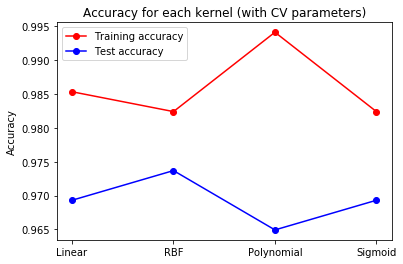

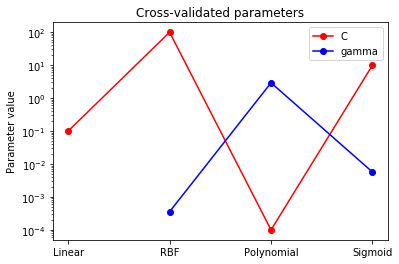

In [10]:
# Finally, let's compare the results
acc_test = [acc[i][1] for i in range(len(acc))]
acc_train = [acc[i][0] for i in range(len(acc))]
max_score = [acc[i][2] for i in range(len(acc))]

plt.figure()
plt.plot(acc_train, 'ro-',label='Training accuracy')
plt.plot(acc_test,  'bo-',label='Test accuracy')
# plt.plot(max_score, 'go-',label='CV accuracy')
plt.xticks(range(len(acc_train)),['Linear','RBF','Polynomial','Sigmoid'])
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy for each kernel (with CV parameters)')
plt.show()

plt.figure()
plt.semilogy(C, 'ro-',label='C')
plt.semilogy([1,2,3], g,  'bo-',label='gamma')
# plt.plot(max_score, 'go-',label='CV accuracy')
plt.xticks(range(len(acc_train)),['Linear','RBF','Polynomial','Sigmoid'])
plt.legend()
plt.ylabel('Parameter value')
plt.title('Cross-validated parameters')
plt.show()

*From these plots, we can obtain several conclusions:*
* *All kernel methods are quite powerful over this dataset, achieving all of them a test accuracy higher than 95%.*
* *Linear and polynomial kernels have more difference between training and test accuracy, indicating that somehow they are more prone to overfitting. In fact, the polynomial kernel SVM selects a C = 10^-4 (and also a relatively high gamma), so it is overfitting, as seen by a training accuracy of 99.4%. Still, it has a test accuracy of 96.5%, so the overfitting is not critical.*
* *The sigmoid kernel provides train and test accuracies similar to those of the linear kernel. It has reasonable values of C and $\gamma$ that avoid overfitting.*
* *RBF kernel provides the best test result, with an accuracy of 97.5%. Remarkably, it is also the one in which the difference between train and test accuracy is minimum, indicating that the SVM has been able to capture the true patterns inherent to the data, and it has not overfitted over the training samples. However, it is strictly penalizing errors (large C) meanwhile having wide margins (low $\gamma$), what constitutes a curious combination. The low $\gamma$ makes it nearly to linear, and actually it makes sense as linear and RBF kernels have very similar performance.*

*Now, let's also explore the possibility of making a boosting ensemble of RBF support vector machines. Discrete AdaBoost will be used, as SVC does not have a "predict_proba" method and therefore it does not allow for RealAdaBoost implementation.*

In [59]:
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier

# RBF kernel parameters
C_vector = 10. ** np.arange(-4,4)
gamma_vector = 2. ** np.arange(-16,8) / np.sqrt(X_train.shape[1])

# GridSearch can not have nested classifiers (SVC inside Adaboost), so we perform it manually
n_vector = [1,3,5,7,9,10,13,17,20,30,40,50,80]
kf = KFold(n_splits=10,random_state=42) # perform cross-validation
train_acc = []; valid_acc = []; test_acc = []; g_param = []; C_param = []; n_param = [];
for C in C_vector:
    for g in gamma_vector:
        for n in n_vector:
            counter = 0; running_train = 0. ; running_valid = 0. ; running_test = 0.;
            for train_idx, valid_idx in kf.split(X_train):
                X_train2 , X_valid = X_train[train_idx,:] , X_train[valid_idx,:]
                Y_train2 , Y_valid = Y_train[train_idx]   , Y_train[valid_idx]
                classifier = AdaBoostClassifier(SVC(kernel='rbf',C=C,gamma=g),n_estimators = n, algorithm='SAMME')
                # SVC does not have the method "predict_proba", so discrete Adaboost must be used
                classifier.fit(X_train2,Y_train2)
                counter += 1
                running_train += classifier.score(X_train2,Y_train2)
                running_valid += classifier.score(X_valid,Y_valid)
                running_test  += classifier.score(X_test,Y_test)
            train_acc.append(running_train/counter)
            valid_acc.append(running_valid/counter)
            test_acc.append(running_test/counter)
            g_param.append(g)
            C_param.append(C)
            n_param.append(n)


In [70]:
best_val = np.amax(valid_acc)
idx = np.where(np.asarray(valid_acc)==best_val)[0][0]

print('Train accuracy:',train_acc[idx])
print('Validation accuracy:',best_val)
print('Test accuracy:',test_acc[idx])

print('\nC:',C_param[idx])
print('Gamma:',g_param[idx])
print('Number of learners:',n_param[idx])

Train accuracy: 0.9732792574141491
Validation accuracy: 0.9852941176470589
Test accuracy: 0.9578947368421051

C: 100.0
Gamma: 0.00142636082683637
Number of learners: 7


*Using manual cross-validation and grid-search, it performed very slightly better over validation (98.53% with AdaBoost, vs 98.24% with standard RBF SVM). However, it performs slightly worse over train set, and considerably worse over test set (95.79% with AdaBoost, vs 97.37% with standard RBF SVM). Therefore, using AdaBoost is not really improving the model, and it is leading to some small overfitting. This is probably due to two factors:*
* *Ensembles are designed to generate a strong learner by agreggation of many weak learners. However, a RBF SVM is already a strong learner, with 97.4% test accuracy. Therefore, there is little room for improvement.*
* *Additionally, we have small amount of training data (after train-test split, the training set has 341 samples). Therefore, we are providing a lot of flexibility to the model and relatively low number of training data, causing mild overfitting (validation accuracy of 98.5%, train accuracy of 97.3%, test accuracy of 95.8%)*

### Exercise 3. Feature selection with SVM
Now, let's analyze two approaches for feature selection with SVMs:

#### 1. L1-regularized SVM

In this first case, you have to train a linear SVM regularized with a L1 or LASSO penalty. As you know, this constrain is able to provide sparsity over the weight vector; so, those input features associated to the zeros of the weight vector are not used during the classification process and we obtain an automatic feature selection. 

Note that, if we change the SVM formulation replacing the L2 regularization by a L1, the feature selection is obtained during the SVM training, so both stages (feature selection and classifier training) are completely linked and, therefore, the selection process is guided by the classifier. For this reason this kind of feature selection method is classified as an **embedded feature selector**. 

The only limitation of this approach, as other L1 based feature selection, relies in having to be applied over linear versions of the method, since the sparsity is forced over the vector weights ${\bf w}$. 

#### 2. Recursive Feature Elimination (RFE)

The Recursive Feature Elimination (RFE) method iteratively trains a set of SVM classifiers and, in each step, it eliminates a feature (or a subset of features) in such a way that the classification margin is reduced the least. 

This method is known as a **wrapper approach**, since it iteratively trains a SVM and evaluates its margin to decide which feature can be eliminated.

However, unlike L1-SVM,  this method can be applied over the kernelized version of the SVM, providing a feature selection strategy for both linear and non-linear SVMs.

**References**

[1] Guyon, I., Weston, J., Barnhill, S., & Vapnik, V., “Gene selection for cancer classification using support vector machines”, Mach. Learn., 46(1-3), 389–422, 2002.



### Exercise 3.1 L1-SVM

Analyze the properties of the L1-SVM as feature selection approach. For this purpose, use the linear SVM implementation given by the method [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html), which directly let's select the regularization type (L1 or L2) to be used.

Unlike other feature selection methods, here we cannot obtain a ranking of variables. In this case, we have to sweep the value of the regularization parameter in order to get a higher (or lower) sparsity of the weight vector. According to this, train a linear L1-SVM for different values of the regularization parameter and, for each value of C, analyze the test accuracy, as well as the number of used features. 

Later, try to plot the accuracy vs. the number of features. Note that different values of C can provide the same number of features with different accuracies, so take care of this for this representation. In case you want to obtain the optimum working point, remember to compute a validation error to select the optimum value of C.

Finally, don't forget to analyze the obtained results.



### Solution

In [84]:
# <SOL>
X_train2, X_val, Y_train2, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

C_vector = 10. ** np.arange(-3,7)
clf = []
coeffs = []
n_features = []
train_acc = []
val_acc = []
test_acc = []
for a,c in enumerate(C_vector):
  clf.append(LinearSVC(C=c,penalty='l1',dual=False,max_iter=1e6))
  clf[-1].fit(X_train2,Y_train2) 
  coeffs.append(clf[-1].coef_)
  n_features.append(np.sum(abs(coeffs[-1])>0))
  train_acc.append(clf[-1].score(X_train2,Y_train2))
  val_acc.append( clf[-1].score(X_val,Y_val) )
  test_acc.append( clf[-1].score(X_test,Y_test) )
# </SOL>

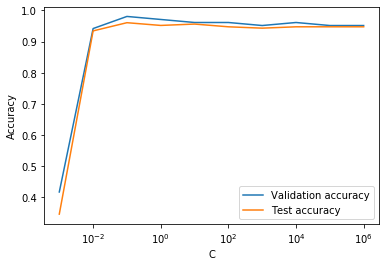

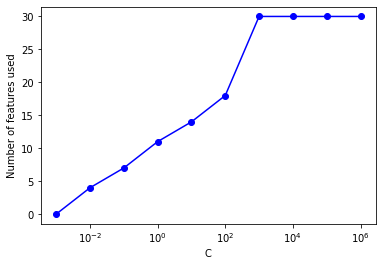

In [85]:
plt.figure()
plt.semilogx(C_vector,val_acc,label='Validation accuracy')
plt.semilogx(C_vector,test_acc,label='Test accuracy')
plt.xlabel('C'); plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.semilogx(C_vector,n_features,'bo-')
plt.xlabel('C'); plt.ylabel('Number of features used')
plt.show()

*We are trying to minimize the hinge loss function, which has several terms:*
$$\mathbf{w}^* =\displaystyle \underset{{\bf w}}{\operatorname{min}}\sum_{i=1}^N  \left[ 1 - f(\mathbf{x}^{(i)}) y^{(i)}\right]_+ + \frac{1}{2C} ||\mathbf{w}||^2 $$

*This can be rewritten as (with the added L1 penalty term)*

$$\mathbf{w}^* =\displaystyle \underset{{\bf w}}{\operatorname{min}}  \left[ 2C \cdot \sum_{i=1}^N  \left[ 1 - f(\mathbf{x}^{(i)}) y^{(i)}\right]_+ + ||\mathbf{w}||^2  + ||\mathbf{w}||^1_1\right]$$

*There are several elements in this loss function:*
* *Loss due to incorrect classification, or inside the margin.*
* *Training a SVM consist in maximizing $\frac{1}{||w||}$ , or equivalently, minimize $||w||^2$.*
* *Regularization term, in this case L1 regularization*
*The hyperparameter defines the relative importance between misclassification and regularization (both minimizing the square norm of $w$, and the Lasso penalty). Therefore, a low C will place more emphasis on the penalties and so in sparsity, meanwhile high C will prioritize achieving low misclassification over the training data.*

*In the first graph we can clearly see that effect:*
* *For very low C, the penalty for any non-zero weight is so high (compared to misclassification) that all features have zero weight. Of course, accuracy is very poor, the linear model is just a bias term.*
* *With moderately low C, the L1 penalty is still relatively important, so sparsity is enforced. The SVM is able to achieve good results with 4, 7, 11... features.*
* *With high C, all features are used as the regularization penalty is very low compared to the misclassification penalty.*

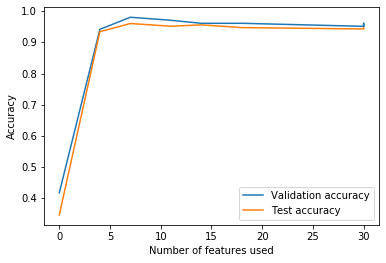

The best SVM (in validation accuracy) is the one with C = 0.100 and 7 features


In [86]:
# Now, let's plot the accuracy vs the number of features
plt.figure()
plt.plot(n_features,val_acc,label='Validation accuracy')
plt.plot(n_features,test_acc,label='Test accuracy')
plt.xlabel('Number of features used'); plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Let's find the best SVM (in terms of validation accuracy)
idx = val_acc.index(max(val_acc))
best_clf = clf[idx]
best_n_features = n_features[idx]
print('The best SVM (in validation accuracy) is the one with C = %.3f and %d features' %(best_clf.C,best_n_features))

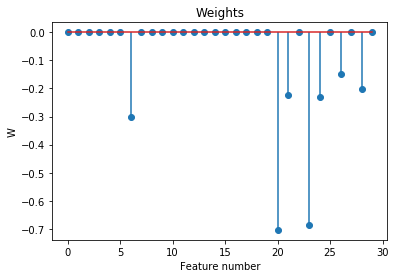

Features, ranked by importance:  [20, 23, 6, 24, 21, 28, 26]
The three most relevant features are:
worst radius
worst area
mean concavity


In [87]:
# Let's find which are the selected features for C = 0.1, 
# which is the best performing SVM (in terms of validation accuracy)

w = coeffs[idx][0]
plt.figure()
plt.stem(w, use_line_collection=True)
plt.title('Weights')
plt.xlabel('Feature number'); plt.ylabel('W')
plt.show()


ranked_features = []
w_sorted = []

for i in range(np.sum(abs(w)>0)):
    idx_feature = np.argmax(abs(w))
    ranked_features.append(idx_feature)
    w_sorted.append(w[idx_feature])
    w[idx_feature] = 0.

print('Features, ranked by importance: ',ranked_features)
print('The three most relevant features are:')
print(feature_names[ranked_features[0]])
print(feature_names[ranked_features[1]])
print(feature_names[ranked_features[2]])

*According to feature selection using L1 regularization, the most relevant features are feature 20, 23 and 6 (worst radius, worst area and mean concavity, respectively).*

### Exercise 3.2 Recursive Feature Elimination (RFE)

To understand the working principles of the RFE method, let's present its pseudocode:
* Start with all the variables selected. Let's define $S=\left\lbrace 1, \ldots, D\right\rbrace $ the set of indexes with the selected features (we start with all of them).

* For $d = 1, \ldots, D$
  * Train a SVM with using the features in $S$
  * Compute $ \displaystyle \Vert {\bf w} \Vert_2^2$ with the training data and using the features in $S$. That is, if ${\bf x}_S$ is the data ${\bf x}$, but limited to the features in $S$, we have to compute:
$$  \Vert {\bf w}_S \Vert_2^2 = \sum_{i=1}^N  \sum_{j=1}^N \alpha^{(i)} \alpha^{(j)} K({\bf x}^{(i)}_S,{\bf x}^{(j)}_S)$$ 

  * For each variable $d' \in S$, built ${\bf x}_{S-d'}= {\bf x}_S \setminus x_{d'}$ and compute $ \displaystyle \Vert {\bf w} \Vert_2^2$ with the data in ${\bf x}_{S-d'}$
$$  \Vert {\bf w}_{S-d'} \Vert_2^2 = \sum_{l=1}^L  \sum_{l'=1}^L \alpha^{(l)} \alpha^{(l')} K({\bf x}^{(l)}_{S-d'},{\bf x}^{(l')}_{S-d'})$$  
  * Remove the feature $d^*$, where 
  $$d^{*} = \underset{d'}{\operatorname{argmin}} \left\lbrace \Vert {\bf w}_S \Vert_2^2 -\Vert {\bf w}_{S-d'} \Vert_2^2 \right\rbrace $$
  * Define $S = S \setminus d^*$
  * Stop when any criteria is reached (a given number of features or a degradation in the SVM performance)

<br>

Starting from this pseudocode, implement the RFE method for a kernelized SVM. Then,  analyze the curve test accuracy vs. number of selected features when a linear kernel and a RBF kernel are used (you can use the default values of $C$ and $\gamma$ ). Finally, don't forget to analyze the obtained results. 


Note: Scikit-Learn provides a function with a full implementation of the RFE method and extend this implementation for any classifier. In fact, this function, [RFE( )](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), let user select the classifier to consider, the number of selected features (parameter n\_features\_to\_select) and the number of features removed in each step (parameter step).  As result, in parameter .ranking returns the ranking position of the each feature (i.e., .ranking\_[i] corresponds to the ranking position of the i-th feature). However, this implementation is only thought for linear methods (it is quite similar to the pruning scheme for ridge regression used in the first HW). Here, I want you to work with the original version of this method [1] which is specifically proposed for no-linear SMVs; so, you have to implement the given method. Anyway, in case you have time, you can try to compare the proposed RFE method with that of Scikit-Learn.

### Solution

In [93]:
# First, let's define the functions to compute the squared modulus of w
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel

def compute_w2_rbf_kernel(clf):
    # Computes the squared modulus of the weight vector
    alphas = np.abs(clf.dual_coef_)
    sv = clf.support_vectors_

    w2 = 0.
    for i in range(sv.shape[0]):
        for j in range(sv.shape[0]):
            w2 += alphas[0,i]*alphas[0,j]*rbf_kernel(sv[i,:].reshape(1, -1),sv[j,:].reshape(1, -1))
       
    return w2[0][0]

def compute_w2_linear_kernel(clf):
    w = clf.coef_ # with a linear kernel, it is possible to directly get the weight vector
    w2 = np.dot(w,w.T)
    # Doing it this way is much faster than using "linear_kernel(xi,xj)"
    return w2[0][0]

def save_feature_rank(feature_ranking,d,N):
    # The idea is that we have a feature ranking vector where
    # feat[3] = 28 means that feature 3 was eliminated when having 28 features
    
    # For that, we need to find the true position of that feature in the original set
    n_eliminated_features = np.sum(feature_ranking > 1.) # The vector is initialized to zeros
    
    D = d
    for i,f in enumerate(feature_ranking):
        if f != 1.: # it that feature has already been eliminated
            if i <= D: # that is, if that eliminated feature was before d
                D = D+1
    
    # once we know the true d
    feature_ranking[D] = N   
    
    return feature_ranking, D

In [35]:
feat = np.ones(6,)
feat[2] = 5
feat[3] = 2

feat = save_feature_rank(feat,2,8)
print(feat)

[1. 1. 5. 2. 8. 1.]


In [79]:
################### LINEAR KERNEL ############################

from sklearn.model_selection import GridSearchCV
C_vector = 10. ** np.arange(-3,4)
params = {'C': C_vector}


# Let's make a copy of the data from which to progressively delete columns
X_train2 = copy.deepcopy(X_train)
X_test2 = copy.deepcopy(X_test)

# Let's define a list for storing the classifiers, and another one for the squared weight norms
N = X_train.shape[1] # Number of features
# Positions i = (0 to N-1) will store the result when eliminating feature i
# Position i = N will store the result with all features (all remaining at that level)
# They will be nested list. clf[5][i] will be the result when already 5 features have been eliminated, 
# and we are searching for the sixth. 
clf = [None]*(N+1)
w2  = [None]*(N+1)
test_acc  = [None]*(N+1)
train_acc = [None]*(N+1)

linear_feature_ranking = np.ones((N,))
sorted_features = np.zeros((N,))

for n in range(N):
    # initialize the list for this iteration
    N = X_train2.shape[1]
    clf[n] = [None]*(N+1)
    w2[n] = [None]*(N+1)
    test_acc[n]  = [None]*(N+1)
    train_acc[n] = [None]*(N+1)
    
    for i in range(N+1):
        if (i < N)&(N > 1):
            Xs = np.delete(X_train2,[i],1)
            Xtest = np.delete(X_test2,[i],1)
        else: # just for when using all features at that stage
            Xs = X_train2
            Xtest = X_test2
        cv = GridSearchCV(SVC(max_iter=1e7,kernel='linear'),param_grid=params,cv=5, iid=False)
        cv.fit(Xs,Y_train)
        clf[n][i] = cv.best_estimator_
        w2[n][i] = compute_w2_linear_kernel(clf[n][i]) 
        train_acc[n][i] = clf[n][i].score(Xs,Y_train)
        test_acc[n][i]  = clf[n][i].score(Xtest,Y_test)
    
    # Find the feature that minimizes the difference
    diff = w2[n][N]-w2[n][:N] 
    diff = np.abs(diff)
    d = np.argmin(diff)
    
    print('Iteration %d : N = %d , eliminated feature = %d' %(n,N,d))
    
    # to compare with sklearn RFE method
    linear_feature_ranking, D = save_feature_rank(linear_feature_ranking,d,N)
    # get a vector with sorted features
    sorted_features[-(n+1)] = D
    
    X_train2 = np.delete(X_train2,[d],1)
    X_test2  = np.delete(X_test2 ,[d],1)
    

Iteration 0 : N = 30 , eliminated feature = 4
Iteration 1 : N = 29 , eliminated feature = 24
Iteration 2 : N = 28 , eliminated feature = 15
Iteration 3 : N = 27 , eliminated feature = 13
Iteration 4 : N = 26 , eliminated feature = 15
Iteration 5 : N = 25 , eliminated feature = 13
Iteration 6 : N = 24 , eliminated feature = 22
Iteration 7 : N = 23 , eliminated feature = 11
Iteration 8 : N = 22 , eliminated feature = 8
Iteration 9 : N = 21 , eliminated feature = 20
Iteration 10 : N = 20 , eliminated feature = 12
Iteration 11 : N = 19 , eliminated feature = 10
Iteration 12 : N = 18 , eliminated feature = 4
Iteration 13 : N = 17 , eliminated feature = 2
Iteration 14 : N = 16 , eliminated feature = 5
Iteration 15 : N = 15 , eliminated feature = 0
Iteration 16 : N = 14 , eliminated feature = 0
Iteration 17 : N = 13 , eliminated feature = 0
Iteration 18 : N = 12 , eliminated feature = 0
Iteration 19 : N = 11 , eliminated feature = 9
Iteration 20 : N = 10 , eliminated feature = 0
Iteration 21 

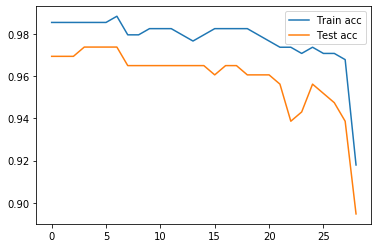

In [80]:
# Let's plot the evolution of accuracy over the recursive elimination
# (taking the accuracy with all features at that step)
final_test_acc = [test_acc[i][-1] for i in range(X_train.shape[1]-1)]
final_train_acc = [train_acc[i][-1] for i in range(X_train.shape[1]-1)]

plt.figure()
plt.plot(final_train_acc,label='Train acc')
plt.plot(final_test_acc,label='Test acc')
plt.legend()
plt.show()

*We can see how performance gets worse slowly as features get progressively eliminated. There is only a sharp decrease in performance when going below three features. This result indicates that most features are either redundant or non-informative. And even with one feature, the SVM preserves an accuracy around 90%.*

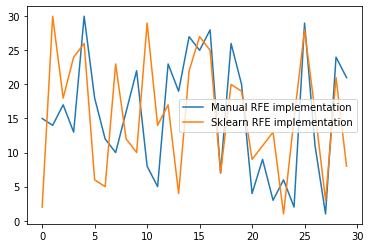

In [81]:
# Now let's compare with SKlearn RFE implementation for linear SVC
from sklearn.feature_selection import RFE
selector = RFE(SVC(kernel='linear',C=1000),1, step = 1)
selector.fit(X_train,Y_train)

plt.figure()
plt.plot(linear_feature_ranking,label='Manual RFE implementation')
plt.plot(selector.ranking_,label='Sklearn RFE implementation')
plt.legend()
plt.show()

*In the plot above it can be seen how each of the methods classifies each feature. A high position indicates that it has been eliminated early, and therefore that it has low relevance.*

*Both methods yield similar results for many of the features (although some diverge significantly). In any case, I believe it is due to using a fixed C for the sklearn RFE, meanwhile crossvalidating different C values in the manual method.*

In [94]:
# Now, let's do the same for the RBF kernel

################### RBF KERNEL ############################
from sklearn.model_selection import GridSearchCV
C_vector = 10. ** np.arange(-3,4)
gamma_vector = 10. ** np.arange(-5,3)
params = {'C': C_vector,'gamma':gamma_vector}

# Let's make a copy of the data from which to progressively delete columns
X_train2 = copy.deepcopy(X_train)
X_test2 = copy.deepcopy(X_test)

# Let's define a list for storing the classifiers, and another one for the squared weight norms
N = X_train.shape[1] # Number of features
# Positions i = (0 to N-1) will store the result when eliminating feature i
# Position i = N will store the result with all features (all remaining at that level)
# They will be nested list. clf[5][i] will be the result when already 5 features have been eliminated, 
# and we are searching for the sixth. 
clf = [None]*(N+1)
w2  = [None]*(N+1)
test_acc  = [None]*(N+1)
train_acc = [None]*(N+1)

rbf_feature_ranking = np.ones((N,))
rbf_sorted_features = np.zeros((N,))

for n in range(N):# later change to N, in order to eliminate all features progressively
    # initialize the list for this iteration
    N = X_train2.shape[1]
    clf[n] = [None]*(N+1)
    w2[n] = [None]*(N+1)
    test_acc[n]  = [None]*(N+1)
    train_acc[n] = [None]*(N+1)
    
    for i in range(N+1):
        if (i < N)&(N > 1):
            Xs = np.delete(X_train2,[i],1)
            Xtest = np.delete(X_test2,[i],1)
        else: # just for when using all features at that stage
            Xs = X_train2
            Xtest = X_test2
        cv = GridSearchCV(SVC(max_iter=1e7,kernel='rbf'),param_grid=params,cv=5, iid=False)
        cv.fit(Xs,Y_train)
        clf[n][i] = cv.best_estimator_
        w2[n][i] = compute_w2_rbf_kernel(clf[n][i]) 
        train_acc[n][i] = clf[n][i].score(Xs,Y_train)
        test_acc[n][i]  = clf[n][i].score(Xtest,Y_test)
    
    # Find the feature that minimizes the difference
    diff = w2[n][N]-w2[n][:N] 
    diff = np.abs(diff) # probably it has to be absolute diff
    d = np.argmin(diff)
    
    print('Iteration %d : N = %d , eliminated feature = %d' %(n,N,d))
    
    rbf_feature_ranking, D = save_feature_rank(rbf_feature_ranking,d,N)
    # get a vector with sorted features
    rbf_sorted_features[-(n+1)] = D
    
    X_train2 = np.delete(X_train2,[d],1)
    X_test2  = np.delete(X_test2 ,[d],1)

Iteration 0 : N = 30 , eliminated feature = 16
Iteration 1 : N = 29 , eliminated feature = 16
Iteration 2 : N = 28 , eliminated feature = 23
Iteration 3 : N = 27 , eliminated feature = 9
Iteration 4 : N = 26 , eliminated feature = 7
Iteration 5 : N = 25 , eliminated feature = 15
Iteration 6 : N = 24 , eliminated feature = 12
Iteration 7 : N = 23 , eliminated feature = 10
Iteration 8 : N = 22 , eliminated feature = 11
Iteration 9 : N = 21 , eliminated feature = 10
Iteration 10 : N = 20 , eliminated feature = 19
Iteration 11 : N = 19 , eliminated feature = 4
Iteration 12 : N = 18 , eliminated feature = 16
Iteration 13 : N = 17 , eliminated feature = 13
Iteration 14 : N = 16 , eliminated feature = 4
Iteration 15 : N = 15 , eliminated feature = 3
Iteration 16 : N = 14 , eliminated feature = 4
Iteration 17 : N = 13 , eliminated feature = 12
Iteration 18 : N = 12 , eliminated feature = 5
Iteration 19 : N = 11 , eliminated feature = 0
Iteration 20 : N = 10 , eliminated feature = 1
Iteration 2

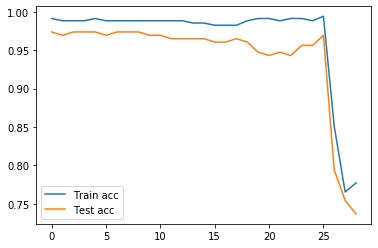

In [95]:
# Let's plot the evolution of accuracy over the recursive elimination
# (taking the accuracy with all features at that step)
final_test_acc = [test_acc[i][-1] for i in range(X_train.shape[1]-1)]
final_train_acc = [train_acc[i][-1] for i in range(X_train.shape[1]-1)]

plt.figure()
plt.plot(final_train_acc,label='Train acc')
plt.plot(final_test_acc,label='Test acc')
plt.legend()
plt.show()

In [96]:
print("Best five features according to each method")
print('L1 feature selection: ',ranked_features[:5])
print('Manual linear SVC RFE: ', sorted_features[:5])
print('Manual RBF SVC RFE: ', rbf_sorted_features[:5])
print('Sklearn RFE: ', selector.ranking_[:5])

Best five features according to each method
L1 feature selection:  [20, 23, 6, 24, 21]
Manual linear SVC RFE:  [27. 24. 22. 20. 11.]
Manual RBF SVC RFE:  [ 0. 18. 21. 24. 20.]
Sklearn RFE:  [ 2 30 18 24 26]


*As we can see, the sorting of features by different methods yields quite varied results. This may be due to the different methodologies, as in some methods we substract features one by one, and in others we select their ranking with a single model (in which the weights decide the rank). Also, the different kernels may yield different weights and therefore different choices.*

*In any case, even choosing some different features, there are some which are widely repeated: 24, 20, 21... The other features, which appear in some of the methods and not in the others, are likely to be redundant. Also, it is worth to note that until most of the features have been eliminated, there is no major decrease in performance.*